# FBN1

This notebook demonstrates how to use genophenocorr to search for correlations between certain tpes of variant and specific disease genetities.

FBN1 encodes the fibrillin-1 protein. Pathogenic variants in FBN1 are found in Marfan syndrome and a number of other disorders including  [Weill-Marchesani syndrome](https://omim.org/entry/608328) (WMS), [geleophysic dysplasia](https://omim.org/entry/231050) (GPHYSD), [acromicric dysplasia](https://omim.org/entry/102370) (ACMICD), and [Marfan lipodystrophy syndrome](https://omim.org/entry/616914).

We will investigate correlations between variant location and disease diagnosis.

### Set up
First import the libraries and define the transcript and diseases of interest.

In [1]:
import genophenocorr
from genophenocorr.preprocessing import load_phenopacket_folder
from genophenocorr.preprocessing import configure_caching_cohort_creator
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {genophenocorr.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.1.1dev


### Import the cohort
To finalize, add the phenopackets to this directory
cohort = load_phenopacket_folder(pp_directory=phenopacket_input_folder, cohort_creator=cohort_creator)

In [3]:

FBN1_MANE_transcript = 'NM_000138.5'
FBN1_protein_id = "NP_000129.3"
cohort_creator = configure_caching_cohort_creator(hpo, timeout=20)
phenopacket_input_folder = "../../../../GIT/phenopacket-store/notebooks/FBN1/phenopackets"
cohort = load_phenopacket_folder(pp_directory=phenopacket_input_folder, cohort_creator=cohort_creator)

Patients Created: 100%|██████████| 151/151 [00:00<00:00, 1534.01it/s]
Validated under none policy
No errors or warnings were found


In [4]:
        from IPython.display import display, HTML
        from genophenocorr.view import CohortViewable

        viewer = CohortViewable(hpo=hpo)
        html = viewer.process(cohort=cohort, transcript_id=FBN1_MANE_transcript)
        display(HTML(html))

HPO Term,ID,Annotation Count
Ectopia lentis,HP:0001083,82
Myopia,HP:0000545,70
Arachnodactyly,HP:0001166,54
Aortic root aneurysm,HP:0002616,34
High palate,HP:0000218,33
Short stature,HP:0004322,32
Short palm,HP:0004279,32
Short foot,HP:0001773,32
Scoliosis,HP:0002650,30
Joint hypermobility,HP:0001382,29


<Axes: title={'center': 'Fibrillin-1\ntranscript: NM_000138.5, protein: NP_000129.3'}>

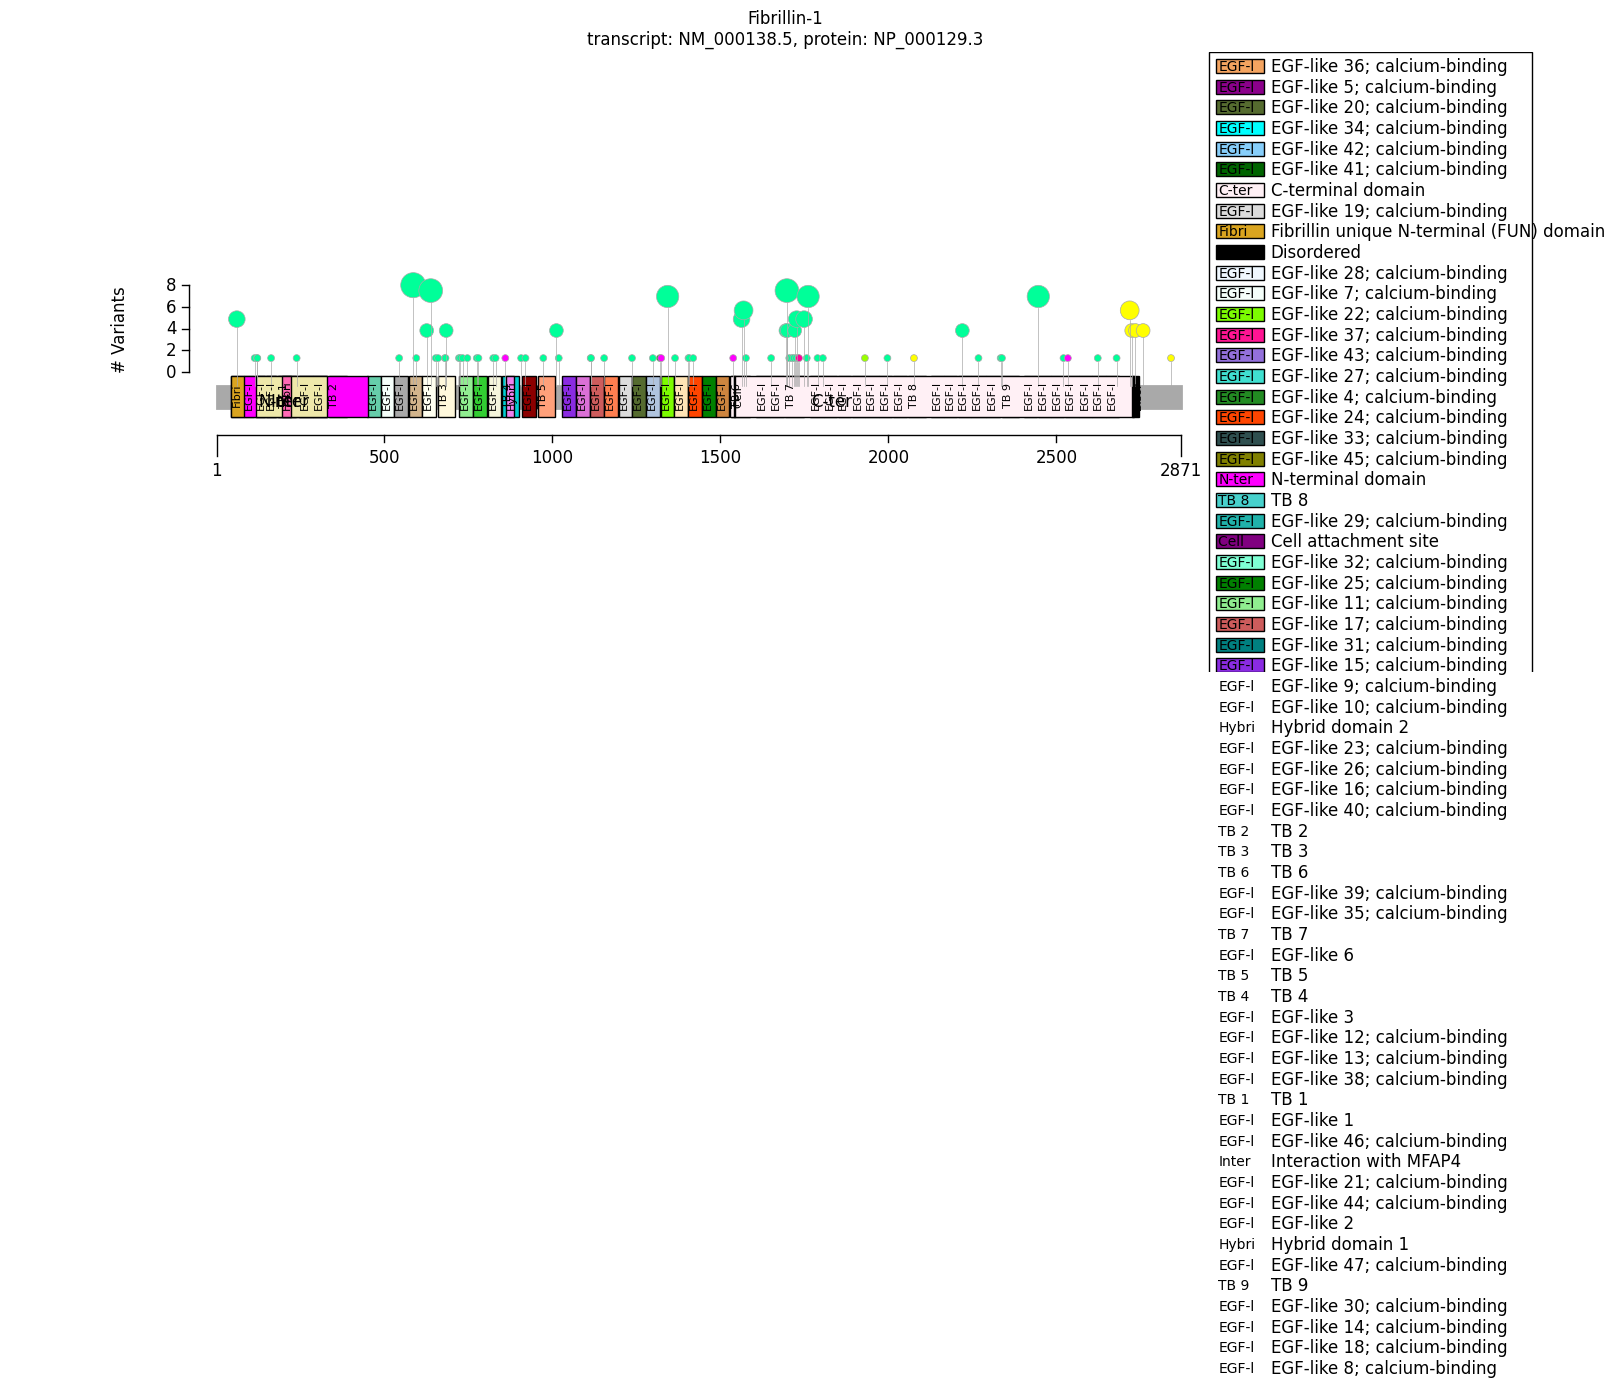

In [5]:
from genophenocorr.preprocessing import UniprotProteinMetadataService
from genophenocorr.model.genome import GRCh38
from genophenocorr.preprocessing import VVTranscriptCoordinateService
txc_service = VVTranscriptCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(FBN1_MANE_transcript)
from genophenocorr.preprocessing import UniprotProteinMetadataService
pms = UniprotProteinMetadataService()
protein_meta = pms.annotate(FBN1_protein_id)
from genophenocorr.view import ProteinVisualizable, ProteinVisualizer
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [ ]:
from genophenocorr.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from genophenocorr.model import VariantEffect
from genophenocorr.analysis.predicate import PatientCategories

config = CohortAnalysisConfiguration()
config.pval_correction = 'fdr_bh'
config.heuristic_strategy(threshold_HPO_observed_frequency=0.4)
analysis = configure_cohort_analysis(cohort, hpo, config=config)

In [ ]:
#missense = analysis.compare_by_pro(VariantEffect.MISSENSE_VARIANT, tx_id=tx_id)
#missense.summarize(hpo, category=PatientCategories.YES)
tb4 = analysis.compare_by_protein_feature(feature="TB 5", tx_id=FBN1_MANE_transcript)

In [ ]:
tb4.summarize(hpo, category=PatientCategories.YES)

Variant that affects TB 5 feature on protein encoded by transcript NM_000138.5   Yes  \
                                                                               Count   
Arachnodactyly [HP:0001166]                                                      0/1   
Tall stature [HP:0000098]                                                        0/1   
Joint hypermobility [HP:0001382]                                                 0/1   
Scoliosis [HP:0002650]                                                           0/1   
High palate [HP:0000218]                                                         0/1   
Mitral valve prolapse [HP:0001634]                                               0/1   
Ectopia lentis [HP:0001083]                                                      1/1   
Aortic root aneurysm [HP:0002616]                                                0/1   

Variant that affects TB 5 feature on protein encoded by transcript NM_000138.5          \
                                                                               Percent   
Arachnodactyly [HP:0001166]                                                         0%   
Tall stature [HP:0000098]                                                           0%   
Joint hypermobility [HP:0001382]                                                    0%   
Scoliosis [HP:0002650]                                                              0%   
High palate [HP:0000218]                                                            0%   
Mitral valve prolapse [HP:0001634]                                                  0%   
Ectopia lentis [HP:0001083]                                                       100%   
Aortic root aneurysm [HP:0002616]                                                   0%   

Variant that affects TB 5 feature on protein encoded by transcript NM_000138.5     No  \
                                                                                Count   
Arachnodactyly [HP:0001166]                                                     54/86   
Tall stature [HP:0000098]                                                       38/62   
Joint hypermobility [HP:0001382]                                                38/67   
Scoliosis [HP:0002650]                                                          30/60   
High palate [HP:0000218]                                                        33/67   
Mitral valve prolapse [HP:0001634]                                              25/61   
Ectopia lentis [HP:0001083]                                                     81/90   
Aortic root aneurysm [HP:0002616]                                               34/82   

Variant that affects TB 5 feature on protein encoded by transcript NM_000138.5          \
                                                                               Percent   
Arachnodactyly [HP:0001166]                                                        63%   
Tall stature [HP:0000098]                                                          61%   
Joint hypermobility [HP:0001382]                                                   57%   
Scoliosis [HP:0002650]                                                             50%   
High palate [HP:0000218]                                                           49%   
Mitral valve prolapse [HP:0001634]                                                 41%   
Ectopia lentis [HP:0001083]                                                        90%   
Aortic root aneurysm [HP:0002616]                                                  41%   

Variant that affects TB 5 feature on protein encoded by transcript NM_000138.5            \
                                                                                 p value   
Arachnodactyly [HP:0001166]                                                     0.379310   
Tall stature [HP:0000098]                                                       0.396825   
Joint hypermobility [HP:0001382]                          

In [ ]:
from genophenocorr.analysis.predicate.phenotype import DiseasePresencePredicate
from genophenocorr.analysis.predicate.genotype import ProtFeaturePredicate

In [ ]:
dp_pred = DiseasePresencePredicate(hpotk.TermId.from_curie("OMIM:614185")) # Geleophysic dysplasia 2 )(FBN1)

In [ ]:
gt_pred = ProtFeaturePredicate(transcript_id=FBN1_MANE_transcript, protein_feature_name="TB 4", protein_service=pms)

In [ ]:
analysis.compare_disease_vs_genotype(genotype_predicate=gt_pred, disease_ids={hpotk.TermId.from_curie("OMIM:614185")})

ValueError: OMIM:614185 is not present in the graph!